# IML Project Phase 2


In [2]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
from scipy.stats import multivariate_normal
from sklearn import mixture
import os
import cv2 as cv
import random
import copy

In [308]:
def extract_patch(this=None, path='Dataset', m=8, idx=None):

    patches = []

    if this == None:

        if not os.path.isfile(f'./{path}'):
            files = [f'./{path}/{i}' for i in os.listdir(f'./{path}')]
        else : files = [path]

        for indx, file in enumerate(files):
            if idx is None or indx in idx:
                img = cv.imread(f'./{file}')
                img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
                x, y = img.shape
                for i in range(x - m + 1):
                    for j in range(y - m + 1):
                        patches.append(img[i : i + m, j : j + m].reshape((m**2, 1)))
                        
    else:
        for indx, img in enumerate(this):
            if idx is None or indx in idx:
                x, y = img.shape
                for i in range(x - m + 1):
                    for j in range(y - m + 1):
                        patches.append(img[i : i + m, j : j + m].reshape((m**2, 1)))
                        
    return np.asarray(patches).reshape(len(patches), len(patches[0])).T

def predict_idiot(gm, Y):
    a = gm.predict(Y)
    return a, [gm.means_[i] for i in a]

def predict_noisy(gm, W, s, Y, n):

    pi = gm.weights_
    K = []
    mu = []
    for j in range(Y.shape[0]):

        k = np.zeros(n)
        for i in range(n):
            mu2, sigma2 = Z_Y(Y[j,:], gm.means_[i], gm.covariances_[i], W, s)

            mu.append(mu2)
            k[i] = pi[i] / np.sqrt(np.linalg.det(sigma2 + np.eye(sigma2.shape[0])))

        K.append(np.argmax(k))
    
    return K, [mu[i] for i in K]


def remake_img(patches, m, imWidth):

    img = np.zeros((imWidth,imWidth))
    weights = np.zeros((imWidth,imWidth))
    o = np.ones((m, m))
    
    for i in range(imWidth - m + 1):
        for j in range(imWidth - m + 1):
            weights[i:i + m, j:j + m] = weights[i:i + m, j:j + m] + o
            img[i:i + m, j:j + m] = img[i:i + m, j:j + m] + patches[i * (imWidth - m + 1) + j].reshape((m,m))
    return img / weights

def denoise_match_percent(img, remaked_img):
    a, b = img.shape
    s = a * b
    return (1 - np.linalg.norm(img - remaked_img) / s) * 100

def Z_Y(Y, mu, cov, W, s):

    sigmaY = s**2 * np.eye(W.shape[0]) + W @ cov @ W.T

    sigmaZY = cov - cov @ W.T @ np.linalg.inv(sigmaY) @ W @ cov

    muZY = sigmaZY @ (W.T @ np.linalg.inv(sigmaY) @ Y + np.linalg.inv(cov) @ mu)

    return muZY, sigmaZY


In [224]:
train_set = MNIST(root='.', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_set, 1, shuffle=True)

In [282]:
mySet = []
n_samples = 100
i = 0
labels = np.zeros(10)
for x, label in train_loader:
  if label == np.argmin(labels) :
    labels[label] = labels[label] + 1
    mySet.append(x.numpy().squeeze())
    i += 1
    if i == n_samples:
      break
print(labels)

[10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


In [336]:
m = 28
n = 10
data = extract_patch(this=mySet, m=m).T
gm = mixture.GaussianMixture(n_components = n, random_state = 0, warm_start=True).fit(data)

print(gm.n_iter_)

2


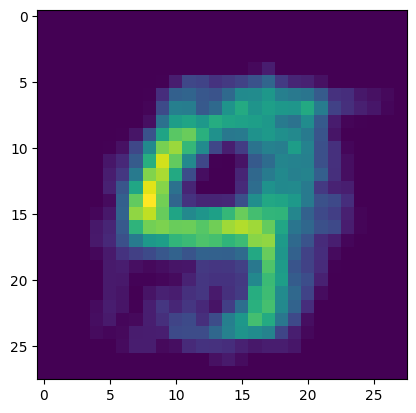

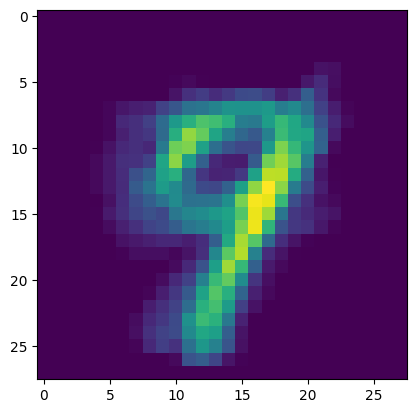

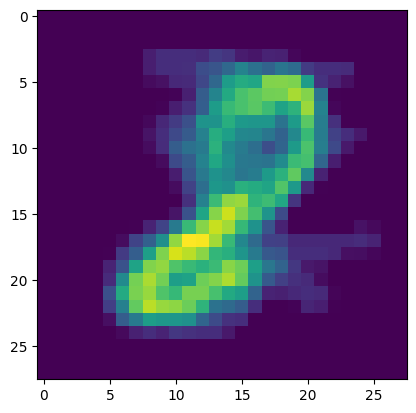

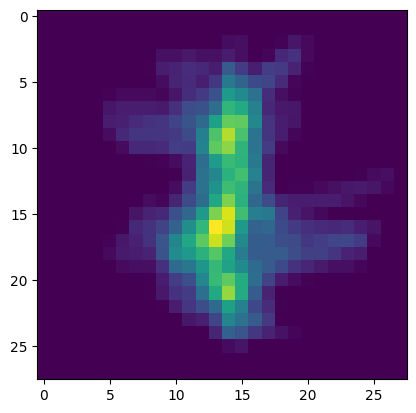

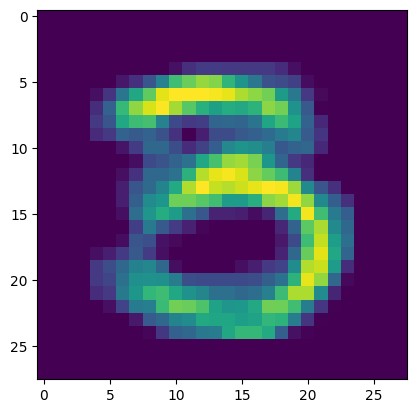

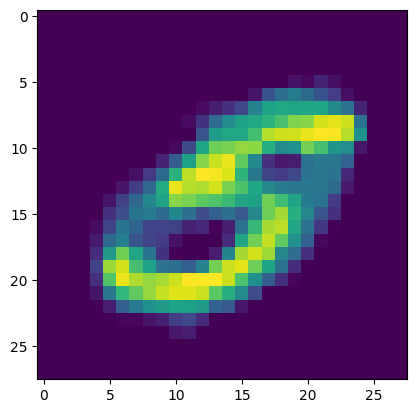

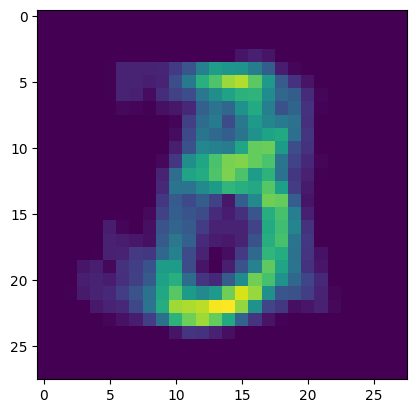

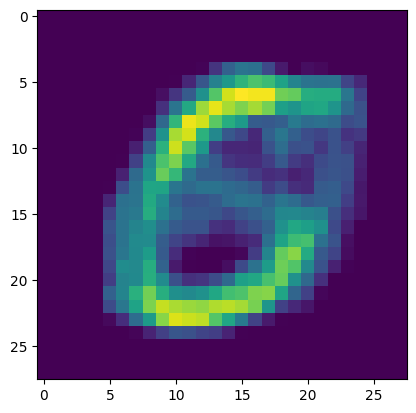

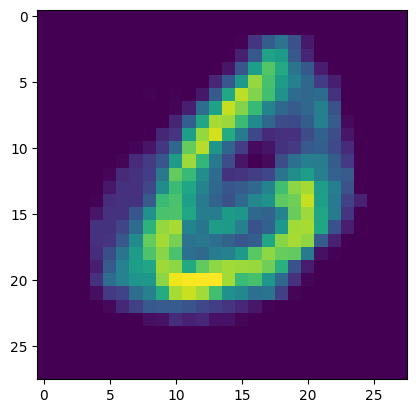

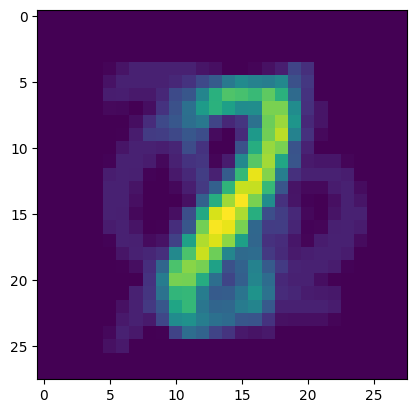

In [337]:
for i in gm.means_ :
    plt.imshow(i.reshape((m,m)))
    plt.show()

(64, 64)


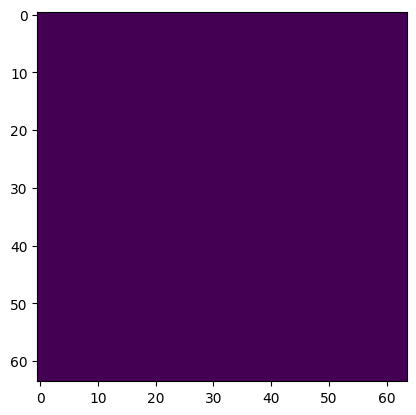

In [13]:
W = np.load(f'Dataset/MNIST-m={8}/MNIST/W.npy')
print(W.shape)

# sigma = 5
# p = random.randint(1, 260)
# y = extract_patch(path=f'Dataset/MNIST-m={m}/MNIST/corrupted/{p}.png', m=m).T
plt.imshow(np.linalg.inv(W))
plt.show()

# a = gm.predict(y)
# plt.imshow(gm.means_[a].reshape(m,m))
# plt.show()

In [343]:
K, pr = predict_idiot(gm, y)
print(gm.weights_)
print(K)

[0.14 0.16 0.08 0.15 0.06 0.05 0.1  0.08 0.07 0.11]
[1]


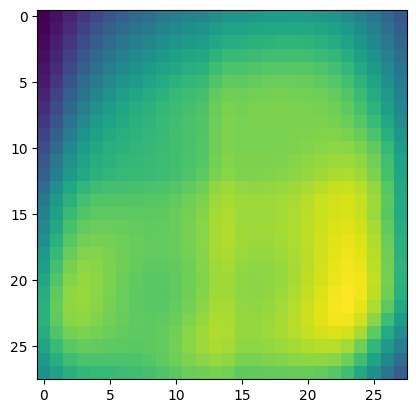

In [335]:
a = remake_img(pr, m, 28)
plt.imshow(a)
plt.show()

[[[ 5.55565556e-02 -5.55555556e-02]
  [-5.55555556e-02  2.22223222e-01]]

 [[ 1.00000000e-06  2.46519033e-30]
  [ 2.46519033e-30  1.00010000e-02]]]
[1]


In [1]:
import numpy as np


In [27]:
a = np.asarray([[[1,2], [3,4]],[[1,2], [3,4]],[[1,2], [3,4]]])

np.transpose(a,[0,2,1]) @ a

array([[[10, 14],
        [14, 20]],

       [[10, 14],
        [14, 20]],

       [[10, 14],
        [14, 20]]])